# **Tanzanian Water Well Competition** 
**Building a classifier to predict the condition of water wells**

## Data Understanding

### Importing and merging data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Converting csv to pandas data-frames
feature_data = pd.read_csv('./Raw_data/TrainingSetValues.csv') # These are all of our training independent variables
labels = pd.read_csv('./Raw_data/TrainingSetLabels.csv') # These are our corresponding training dependent variables
X_test_final = pd.read_csv('./Raw_Data/TestSetValues.csv') # These are our independent test values which we will use our final model on

In [3]:
# Confirming length of labels and features are equal
print(feature_data.shape)
print(labels.shape)

(59400, 40)
(59400, 2)


In [4]:
# Merging status_group labels with features
df = feature_data.merge(labels['status_group'], on = feature_data.index)
df.drop('key_0',axis=1,inplace=True)

In [5]:
# New df with target variables ready for future preparation and cleaning
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### Selecting relevant data

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

We attempted to find a relationship between functionality and instances where the funder and installer were the 
same - we thought we could identify if these parties cut corners in setting-up the pump.
We found no relationship however and decided to not use these features in our future modelling step.

In [7]:
df2 = df[['funder','installer','status_group']]
df2['funder'].fillna('null')
df2 = df2.astype({'funder': str,'installer': str})
df2['funder'] = df2['funder'].map(lambda x:x.lower())
df2['installer'].fillna('null')
df2['installer'] = df2['installer'].map(lambda x:x.lower())
df2['same?'] = (df2['funder'] == df2['installer']).astype(int)
same_non_func = len(df2.loc[(df2['same?'] == 1) & (df2['status_group'] == 'non functional')])
same_func = len(df2.loc[(df2['same?'] == 1) & (df2['status_group'] == 'functional')])
same_total = len(df2.loc[(df2['same?'] == 1)])
diff_non_func = len(df2.loc[(df2['same?'] == 0) & (df2['status_group'] == 'non functional')])
diff_func = len(df2.loc[(df2['same?'] == 0) & (df2['status_group'] == 'functional')])
diff_total = len(df2.loc[(df2['same?'] == 0)])
print('{} wells were funded and installed by the same party \n{} of those are non functional\nA percentage of {}%\n---------'.format(same_total,same_non_func,round(same_non_func*100/same_total,2)))
print('{} wells were funded and installed by the different parties \n{} of those are non functional\nA percentage of {}%\n---------'.format(diff_total,diff_non_func,round(diff_non_func*100/diff_total,2)))

22512 wells were funded and installed by the same party 
8641 of those are non functional
A percentage of 38.38%
---------
36888 wells were funded and installed by the different parties 
14183 of those are non functional
A percentage of 38.45%
---------


Checking for number of different values of subvillage, lga (geo-area), region code & ward - way too many to work 
with - we will drop these features and use region instead (only 21 of them).
These features all mean the same thing and going too granular will make our model computationally expensive

In [8]:
print('Number of unique subvillages:', len(df['subvillage'].value_counts()))
print('Number of unique wards:', len(df['ward'].value_counts()))
print('Number of unique lga:', len(df['lga'].value_counts()))

print('as opposed to -')
print('Number of unique regions:', len(df['region'].value_counts()))

Number of unique subvillages: 19287
Number of unique wards: 2092
Number of unique lga: 125
as opposed to -
Number of unique regions: 21


Similarly we look to drop district code as it will be accounted for in region

Looking at the date recorded feature, we believe this does not provide any deeper insight into the functionality of the pumps therefore we will opt to discard the feature.

In [9]:
df['date_recorded'].value_counts()

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-05      1
2012-01-21      1
2011-09-15      1
2011-09-18      1
2012-01-25      1
Name: date_recorded, Length: 356, dtype: int64

Looking at funders and installers, there are an overwhelmingly large number of unique rows therefore we have chosen not to include these features.


In [10]:
print(df['funder'].value_counts())
print(df['installer'].value_counts())

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Samlo                        1
Msikiti Masji                1
Artisan                      1
Seram                        1
Kyela-morogoro               1
Name: funder, Length: 1897, dtype: int64
DWE                17402
Government          1825
RWE                 1206
Commu               1060
DANIDA              1050
                   ...  
Swalehe Rajabu         1
CF Builders            1
TLC/community          1
Villege Council        1
PIUS CHARLES           1
Name: installer, Length: 2145, dtype: int64


There are more features that communicate the same information and we will discard them when cleaning, for example extraction type and extraction type group and source and source type.
All in all we will look to drop the following features: date_recorded, funder, installer, wpt_name, num_private, subvillage, region_code, district_code, lga, ward, recorded_by, scheme_management, scheme_name, extraction_type, extraction_type_group, management, payment, water_quality, quantity_group, source, source_type and waterpoint_type.

### Early feature trends and visualisations 

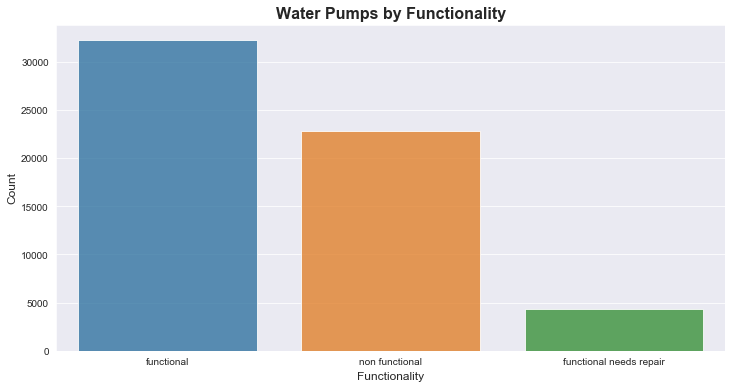

In [11]:
# Some initial understanding of the categorical variables
target_counts = df['status_group'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(target_counts.index, target_counts.values, alpha=0.8)

plt.title('Water Pumps by Functionality', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Functionality', fontsize=12)
plt.show()

In [12]:
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

The bar chart above indicates that some sampling adjustments may need to be made as the class sizes are quite varied in size!

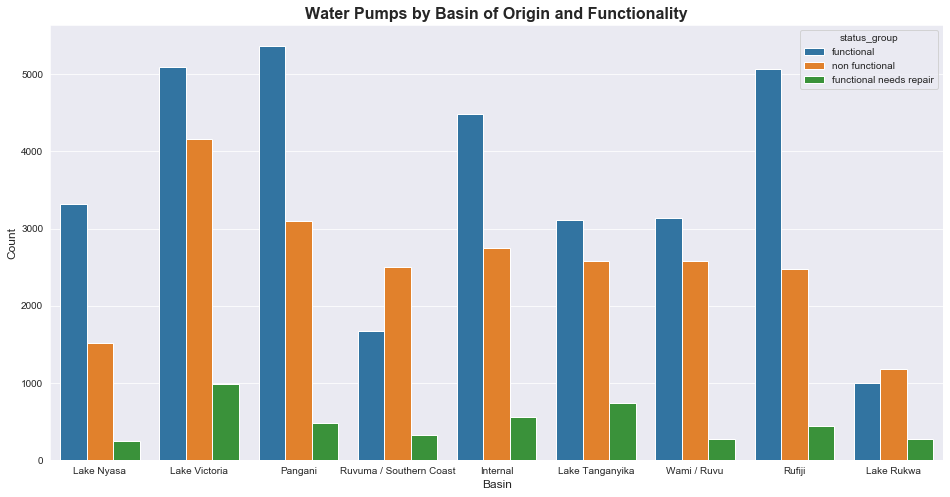

In [13]:
# A plot showing how pump function changes across basin that the pump draws water from
plt.figure(figsize=(16,8))
ax = sns.countplot(data=df, x='basin', hue='status_group')

plt.title('Water Pumps by Basin of Origin and Functionality', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Basin', fontsize=12)
plt.show()

The plot above illustrates that pumps using certain basins have a considerably higher proportion of functional pumps relative to total than other basins - potentially a sound predictor!

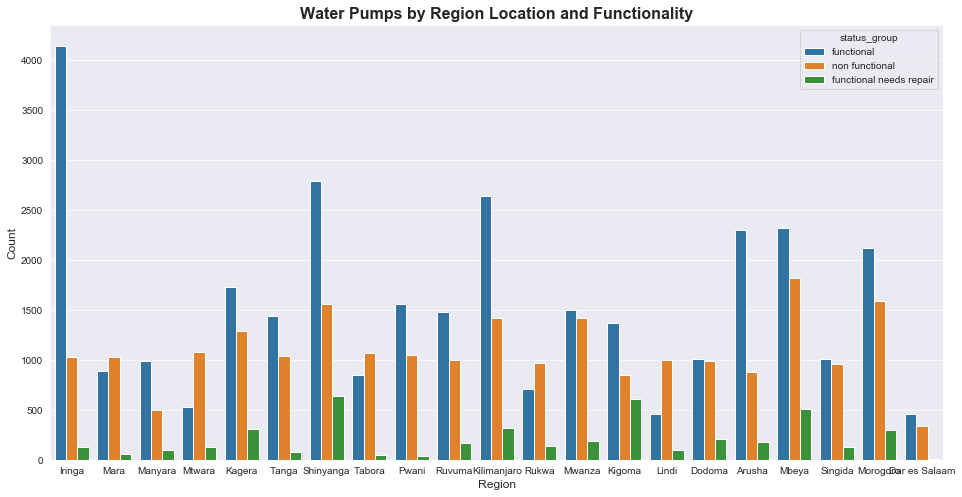

In [14]:
# A plot showing how pump function changes across region that the pump is located in
plt.figure(figsize=(16,8))
ax = sns.countplot(data=df, x='region', hue='status_group')

plt.title('Water Pumps by Region Location and Functionality', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Region', fontsize=12)
plt.show()

The plot above illustrates the variation in the status of pumps given their regional location - some regions display a much higher rate of functional pumps!

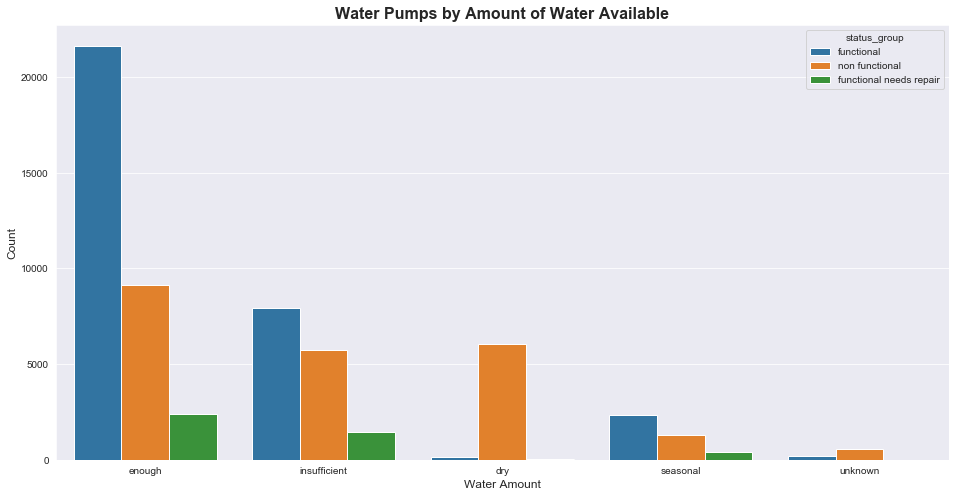

In [15]:
# A plot showing how pump function changes given the amount of water available
plt.figure(figsize=(16,8))
ax = sns.countplot(data=df, x='quantity', hue='status_group')

plt.title('Water Pumps by Amount of Water Available', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Water Amount', fontsize=12)
plt.show()

Above is a visualisation of pumps and their status segmented by the amount of water available to them. When there is ample water - the majority of pumps are functional; contrary to when there is no water and the pumps non-functional. The pumps with seasonal water seem to not follow a particular trend. 
The reason for this is likely that pumps require a flow of water to cool down the motor - when there is no flow
the pumps overheat and this leads to them being non-functional.

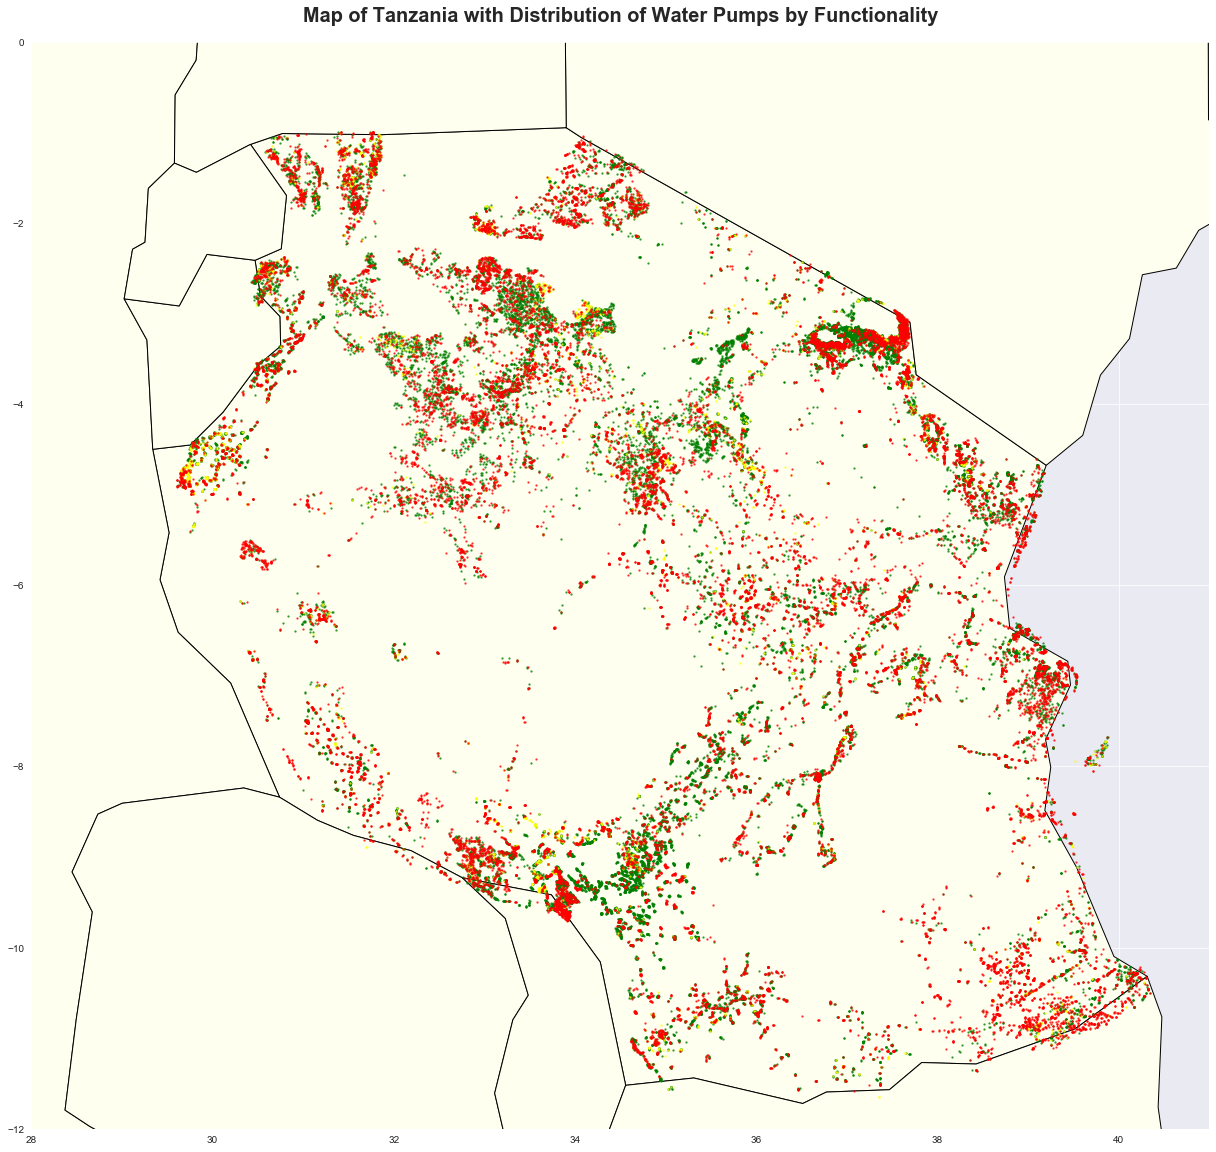

In [16]:
# Creating a map that visualises the pumps and their status across the entirety of Tanzania
import geopandas
from pylab import rcParams

rcParams['figure.figsize'] = 30, 20

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))

functional = gdf.where(gdf['status_group'] == 'functional')
repair = gdf.where(gdf['status_group'] == 'functional needs repair')
broken = gdf.where(gdf['status_group'] == 'non functional')

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Restricted to Africa
ax = world[world.continent == 'Africa'].plot(
    color='ivory', edgecolor='black')

ax.scatter(functional['longitude'], functional['latitude'],
           c='green',alpha=.6, s=2)

ax.scatter(repair['longitude'], repair['latitude'],
           c='yellow', alpha=.6, s=2)

ax.scatter(broken['longitude'], broken['latitude'],
           c='red', alpha=.6, s=2)

plt.title('Map of Tanzania with Distribution of Water Pumps by Functionality', 
          fontsize=20, pad=20, fontweight='bold')

plt.ylim(-12, 0)
plt.xlim(28,41)

plt.show()

The map above does not show a clear trend in pump status across the geography however what we can see is that 
pumps of the same status (functional and non-functional specifically) cluster together. For example at 
approximately (37,-3) there is a large cluster of non-functional pumps around Mt.Kilamanjaro. The high altitude
most likely makes it difficult to pump water as well as regularly maintain. 

## Data Preparation

In [17]:
# Setting negative gps height information to 0
df.loc[df['gps_height']< 0,'gps_height'] = 0

In [18]:
df['zero_tsh']= 0
df.loc[df['amount_tsh']== 0,'zero_tsh' ] = 1

In [19]:
# Setting zero total static head information to a seperate column
df['zero_height']= 0
df.loc[df['gps_height']== 0,'zero_height' ] = 1

In [20]:
# Setting zero population information to a seperate column
df['zero_pop']= 0
df.loc[df['population']== 0,'zero_pop' ] = 1

Below we have created a new feature called duty_cycle. This feature is the date_recorded year minus the construction year to give an approximate length of time that the pump has been operational. We believe this will be a good predictor of the pump's functionality.

In [21]:
from datetime import datetime
# Change format to datetime
df['date_recorded']=pd.to_datetime(df['date_recorded'], format='%Y-%m-%d', errors='raise')
df.loc[df['status_group'] == 'non functional','date_recorded'].map(lambda x: x.year)
df.loc[df['construction_year'] == 0,'construction_year'] = df.loc[df['construction_year'] == 0,'date_recorded'].map(lambda x: x.year) + 10
# Create duty_cycle (length of operation of pump  date_recorded - construction_year)
df['duty_cycle'] = df['date_recorded'].map(lambda x: x.year) - df['construction_year']
# Create dummy for no recorded construction year
df.loc[(df['duty_cycle'] > -10)&(df['duty_cycle']<0),'duty_cycle'] = 0
df['no_operation_yr'] = 0
df.loc[df['duty_cycle'] == -10,'no_operation_yr'] = 1
df.loc[df['duty_cycle'] == -10,'duty_cycle'] = 0
df.loc[df['status_group'] == 'non functional','duty_cycle'].value_counts()
# Seperate df holds distribution of the functional, non functional, functional needs repair 
cycle_df = pd.DataFrame(data=df.loc[(df['status_group'] == 'non functional')]['duty_cycle'].value_counts())
cycle_df= cycle_df.rename(columns = {'duty_cycle':'non_functional'})
cycle_df = pd.concat([cycle_df,df.loc[df['status_group'] == 'functional']['duty_cycle'].value_counts()],axis=1)
cycle_df= cycle_df.rename(columns = {'duty_cycle':'functional'})
cycle_df = pd.concat([cycle_df,df.loc[df['status_group'] == 'functional needs repair']['duty_cycle'].value_counts()],axis=1)
cycle_df= cycle_df.rename(columns = {'duty_cycle':'functional_needs_repair'})
cycle_df.index.name = 'years_in_operation'
# cycle_df['not_recorded'] = 0
# cycle_df['not_recorded'][0] = len(df.loc[df['no_operation_yr'] == 1])
df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,source_class,waterpoint_type,waterpoint_type_group,status_group,geometry,zero_tsh,zero_height,zero_pop,duty_cycle,no_operation_yr
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,groundwater,communal standpipe,communal standpipe,functional,POINT (34.93809 -9.85632),0,0,0,12,0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,surface,communal standpipe,communal standpipe,functional,POINT (34.69877 -2.14747),1,0,0,3,0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,surface,communal standpipe multiple,communal standpipe,functional,POINT (37.46066 -3.82133),0,0,0,4,0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,groundwater,communal standpipe multiple,communal standpipe,non functional,POINT (38.48616 -11.15530),1,0,0,27,0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,surface,communal standpipe,communal standpipe,functional,POINT (31.13085 -1.82536),1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,groundwater,communal standpipe,communal standpipe,functional,POINT (37.16981 -3.25385),0,0,0,14,0
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,surface,communal standpipe,communal standpipe,functional,POINT (35.24999 -9.07063),0,0,0,15,0
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,groundwater,hand pump,hand pump,functional,POINT (34.01709 -8.75043),1,1,1,0,1
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,groundwater,hand pump,hand pump,functional,POINT (35.86132 -6.37857),1,1,1,0,1


In [22]:
#Creating dummy variables for the categorical features we wish to investigate
dummied_columns = ['basin','region','public_meeting',
                  'permit','extraction_type',
                  'management_group' ,'payment_type',
                  'water_quality','quantity',
                  'source_class','source','waterpoint_type','district_code']
df_dummy = df
for column in dummied_columns:
    col_dummy = pd.get_dummies(df[column], prefix=column, drop_first=True, dtype=float)
    df_dummy = df_dummy.drop(column, axis=1)
    df_dummy = pd.concat([df_dummy, col_dummy], axis=1)
remove_cols = ['id', 'geometry', 'construction_year','date_recorded','longitude','latitude','funder', 
               'installer', 'wpt_name','num_private','subvillage',
               'region_code','ward','recorded_by',
               'scheme_management','scheme_name','extraction_type_class',
               'extraction_type_group','management','payment',
               'quality_group','quantity_group','lga','source_type',
               'waterpoint_type_group','status_group']
df_cleaned = df_dummy.drop(remove_cols,axis=1)
df_cleaned.columns
X = df_cleaned
y = df['status_group']

## Modelling

### Baseline Model - Logistic Regression

In [23]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [24]:
# Train validation split
X_train_v, X_val, y_train_v, y_val = train_test_split(X_train,y_train,test_size=0.2, random_state=52)

In [25]:
# Running baseline logistic regression
from sklearn.linear_model import LogisticRegression

model_baseline = LogisticRegression(penalty='none', solver='lbfgs')
model_baseline.fit(X_train_v,y_train_v)

/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
# Evaluating our baseline model
from sklearn.metrics import accuracy_score, roc_auc_score

y_val_pred = model_baseline.predict(X_val)
y_train_pred = model_baseline.predict(X_train_v)

print("Accuracy of model on training =", round(accuracy_score(y_train_v, y_train_pred),3))
print("Accuracy of model on validation =", round(accuracy_score(y_val, y_val_pred),3))

Accuracy of model on training = 0.696
Accuracy of model on validation = 0.689


### Adding regularisation

In [27]:
# Adding L1 penalty
model_baseline_L1 = LogisticRegression(penalty='l1', solver='liblinear')
model_baseline_L1.fit(X_train_v,y_train_v)

/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
y_val_pred = model_baseline_L1.predict(X_val)
y_train_pred = model_baseline_L1.predict(X_train_v)

print("Accuracy of model on training =", round(accuracy_score(y_train_v, y_train_pred),3))
print("Accuracy of model on validation =", round(accuracy_score(y_val, y_val_pred),3))

Accuracy of model on training = 0.741
Accuracy of model on validation = 0.735


In [29]:
# Adding L2 penalty
model_baseline_L2 = LogisticRegression(penalty='l2', solver='lbfgs')
model_baseline_L2.fit(X_train_v,y_train_v)

/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
y_val_pred = model_baseline_L2.predict(X_val)
y_train_pred = model_baseline_L2.predict(X_train_v)

print("Accuracy of model on training =", round(accuracy_score(y_train_v, y_train_pred),3))
print("Accuracy of model on validation=", round(accuracy_score(y_val, y_val_pred),3))

Accuracy of model on training = 0.695
Accuracy of model on validation= 0.69


It looks like our L1 penalty model (0.735) performed better than our L2 (0.69)

### Logistic Regression with cross validation using GridSearchCV

Now we take a further look at the regularisation models by applying a k-fold cross validation

In [31]:
logistic = LogisticRegression(multi_class='auto')
param_grid = {'penalty':['l1','l2']}

In [32]:
from sklearn.model_selection import GridSearchCV
cv_logistic = GridSearchCV(logistic, param_grid, cv=5)

In [33]:
cv_logistic.fit(X_train,y_train)

/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/l

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [34]:
best_model = cv_logistic.best_estimator_

In [35]:
print('Best Penalty:', best_model.get_params()['penalty'])

Best Penalty: l1


In [36]:
print('Best Score:', cv_logistic.best_score_)

Best Score: 0.7384048821548822


In [37]:
cv_logistic.best_params_

{'penalty': 'l1'}

As expected - L1 was the best penalty and our accuracy score is similar to that of our basic train/validation split model coming in at 0.74.

### Decision Tree Classifier

In [38]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_v,y_train_v)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [39]:
y_val_pred = model_dt.predict(X_val)
y_train_pred = model_dt.predict(X_train_v)

In [40]:
print("Accuracy of model on training =", round(accuracy_score(y_train_v, y_train_pred),3))
print("Accuracy of model on validation=", round(accuracy_score(y_val, y_val_pred),3))

Accuracy of model on training = 0.942
Accuracy of model on validation= 0.752


The next model we tried was a decision tree classifier, the base-level model performed well with an accuracy of 0.75.

### Hyperparameter Tuning - Part I

We decided to tune our decision tree and apply a 5-fold cross validation. We also tried tuning the max_features parameter however this caused our model to run for hours without converging so we decided to leave it out.

In [41]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=42)

In [42]:
param_grid = {'max_depth':range(10,50+1,10),'min_samples_leaf':[5,10,15,20]}

In [43]:
model_dt_tuned = GridSearchCV(model_dt,param_grid,cv=skf,scoring='accuracy',return_train_score=True,n_jobs=-1)

In [44]:
model_dt_tuned.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(10, 51, 10),
            

In [45]:
model_dt_tuned.best_params_

{'max_depth': 20, 'min_samples_leaf': 5}

In [46]:
print('Accuracy on validation set:', round(model_dt_tuned.best_score_,3))

Accuracy on validation set: 0.763


In [47]:
pd.DataFrame(model_dt_tuned.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.670193,0.026130,0.030416,0.003214,10,5,"{'max_depth': 10, 'min_samples_leaf': 5}",0.752656,0.744135,0.739478,...,0.746338,0.004787,17,0.766145,0.763172,0.762468,0.762968,0.765769,0.764105,0.001534
1,0.676512,0.051208,0.030851,0.004195,10,10,"{'max_depth': 10, 'min_samples_leaf': 10}",0.752130,0.740768,0.739583,...,0.744844,0.004650,18,0.761752,0.759174,0.758444,0.758891,0.761692,0.759991,0.001433
2,0.626146,0.019649,0.030720,0.004443,10,15,"{'max_depth': 10, 'min_samples_leaf': 15}",0.750552,0.739611,0.739794,...,0.744213,0.004653,19,0.759569,0.756333,0.755524,0.756208,0.759088,0.757344,0.001650
3,0.627105,0.013379,0.028650,0.002890,10,20,"{'max_depth': 10, 'min_samples_leaf': 20}",0.750658,0.740978,0.738636,...,0.744150,0.005250,20,0.756780,0.754071,0.752894,0.754630,0.756352,0.754945,0.001444
4,0.893832,0.012191,0.032835,0.005791,20,5,"{'max_depth': 20, 'min_samples_leaf': 5}",0.765913,0.765281,0.757365,...,0.762731,0.003055,1,0.830225,0.829173,0.829809,0.829835,0.830712,0.829951,0.000509
5,0.883358,0.025123,0.033488,0.003753,20,10,"{'max_depth': 20, 'min_samples_leaf': 10}",0.765281,0.762756,0.755261,...,0.760459,0.003537,5,0.807366,0.805682,0.808423,0.806687,0.806066,0.806844,0.000974
6,0.911823,0.020381,0.034657,0.003316,20,15,"{'max_depth': 20, 'min_samples_leaf': 15}",0.758864,0.759074,0.752946,...,0.759112,0.003439,6,0.794739,0.792608,0.794481,0.795323,0.793861,0.794202,0.000925
7,0.920863,0.022194,0.033767,0.003531,20,20,"{'max_depth': 20, 'min_samples_leaf': 20}",0.760547,0.758022,0.750105,...,0.757155,0.004183,16,0.786953,0.785953,0.787537,0.786116,0.785312,0.786374,0.000782
8,0.997572,0.019297,0.034575,0.004831,30,5,"{'max_depth': 30, 'min_samples_leaf': 5}",0.764229,0.762651,0.756418,...,0.760564,0.002824,4,0.841405,0.843193,0.842224,0.841988,0.840391,0.841840,0.000926
9,0.959251,0.031131,0.032432,0.004925,30,10,"{'max_depth': 30, 'min_samples_leaf': 10}",0.762651,0.758653,0.755261,...,0.758754,0.003111,7,0.811390,0.810654,0.813815,0.811395,0.810379,0.811527,0.001213


The model's accuracy with the tuned parameters has increased to 0.76! Let's see if we can tune it further by narrowing the range of parameters to use around the best_params we found here.

### Hyperparameter Tuning - Part II

In [48]:
param_grid = {'max_depth':range(15,25+1,1),'min_samples_leaf':[3,4,5,6,7]}

In [49]:
model_dt_tuned_2 = GridSearchCV(model_dt,param_grid,cv=skf,scoring='accuracy',return_train_score=True,n_jobs=-1)

In [50]:
model_dt_tuned_2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(15, 26),
                

In [51]:
model_dt_tuned_2.best_params_

{'max_depth': 17, 'min_samples_leaf': 5}

In [52]:
print('Accuracy on validation set:', round(model_dt_tuned_2.best_score_,3))

Accuracy on validation set: 0.765


A slight improvement in accuracy with our final, hyperparameter tuned decision tree scoring 0.765. 
Let's see how a random forest classifier will perform.

### Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=42)
model_rf.fit(X_train_v,y_train_v)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [54]:
y_val_pred = model_rf.predict(X_val)
y_train_pred = model_dt.predict(X_train_v)

In [55]:
accuracy_score(y_val,y_val_pred)

0.7869318181818182

In [56]:
accuracy_score(y_train_v, y_train_pred)

0.9416561447811448

Our baseline random forest has already outperformed our tuned decision trees! A great start with our model scoring 0.786! Time to tune.

### Hyperparameter Tuning Part I

In [57]:
skf = StratifiedKFold(n_splits=5,random_state=42)

In [58]:
param_grid = {'max_depth':range(10,50+1,10),'min_samples_leaf':[5,10,15,20]}

In [59]:
model_rf_tuned = GridSearchCV(model_rf, param_grid, cv=skf, scoring='accuracy',return_train_score=True,n_jobs=-1)

In [60]:
model_rf_tuned.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False)

In [61]:
model_rf_tuned.best_params_

{'max_depth': 30, 'min_samples_leaf': 5}

In [62]:
print('Accuracy on validation set:', round(model_rf_tuned.best_score_,3))

Accuracy on validation set: 0.78


In [63]:
pd.DataFrame(model_rf_tuned.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.893620,0.402145,0.158947,0.023891,10,5,"{'max_depth': 10, 'min_samples_leaf': 5}",0.739821,0.731720,0.738426,...,0.736511,0.004351,17,0.745706,0.746100,0.748185,0.747501,0.745436,0.746586,0.001070
1,4.866142,0.973471,0.178603,0.036525,10,10,"{'max_depth': 10, 'min_samples_leaf': 10}",0.734876,0.728774,0.732744,...,0.733965,0.003940,18,0.741234,0.741786,0.740031,0.745423,0.744016,0.742498,0.001952
2,5.214668,0.185007,0.140035,0.007892,10,15,"{'max_depth': 10, 'min_samples_leaf': 15}",0.734666,0.726249,0.733796,...,0.732239,0.004744,19,0.738498,0.738761,0.738636,0.738479,0.738992,0.738673,0.000189
3,4.750399,0.501187,0.135523,0.003681,10,20,"{'max_depth': 10, 'min_samples_leaf': 20}",0.731720,0.727091,0.726431,...,0.729566,0.003635,20,0.734578,0.737341,0.732981,0.737795,0.734731,0.735485,0.001813
4,7.525920,0.287383,0.134910,0.008245,20,5,"{'max_depth': 20, 'min_samples_leaf': 5}",0.779484,0.773172,0.779882,...,0.777168,0.003106,4,0.801105,0.801263,0.802767,0.802820,0.802804,0.802152,0.000792
5,6.855491,0.334800,0.136690,0.009799,20,10,"{'max_depth': 20, 'min_samples_leaf': 10}",0.765913,0.760863,0.764415,...,0.764331,0.003537,8,0.781507,0.782191,0.782223,0.782723,0.782761,0.782281,0.000455
6,6.277446,0.258804,0.135129,0.001839,20,15,"{'max_depth': 20, 'min_samples_leaf': 15}",0.757180,0.754971,0.757050,...,0.756755,0.003142,12,0.771695,0.772616,0.771070,0.771649,0.770030,0.771412,0.000850
7,6.069940,0.132316,0.134945,0.007491,20,20,"{'max_depth': 20, 'min_samples_leaf': 20}",0.750447,0.748238,0.752946,...,0.751768,0.004184,16,0.764777,0.763120,0.764152,0.763521,0.764059,0.763926,0.000567
8,7.424923,0.287206,0.131739,0.001616,30,5,"{'max_depth': 30, 'min_samples_leaf': 5}",0.781694,0.775487,0.781566,...,0.779735,0.003326,1,0.807892,0.809128,0.808581,0.806923,0.808407,0.808186,0.000745
9,7.102548,0.319099,0.143261,0.015732,30,10,"{'max_depth': 30, 'min_samples_leaf': 10}",0.766965,0.761284,0.767361,...,0.766309,0.003182,5,0.784190,0.784085,0.784538,0.784775,0.783944,0.784307,0.000305


Our tuning did not improve the model's score here unfortunately - let us narrow the params and see if we can improve!

### Hyperparameter Tuning Part II

In [64]:
skf = StratifiedKFold(n_splits=5,random_state=42)

In [65]:
param_grid = {'max_depth':range(35,45+1,1),'min_samples_leaf':[3,4,5,6,7]}

In [66]:
model_rf_tuned_2 = GridSearchCV(model_rf, param_grid, cv=skf, scoring='accuracy',return_train_score=True,n_jobs=-1)

In [67]:
model_rf_tuned_2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False)

In [68]:
model_rf_tuned_2.best_params_

{'max_depth': 35, 'min_samples_leaf': 3}

In [69]:
print('Accuracy on validation set:', round(model_rf_tuned_2.best_score_,3))

Accuracy on validation set: 0.786


In [70]:
pd.DataFrame(model_rf_tuned_2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.805030,0.129200,0.133145,0.004560,35,3,"{'max_depth': 35, 'min_samples_leaf': 3}",0.784745,0.783693,0.786616,...,0.785627,0.001661,1,0.830278,0.829620,0.831097,0.830229,0.831396,0.830524,0.000641
1,8.577740,0.633372,0.160324,0.048377,35,4,"{'max_depth': 35, 'min_samples_leaf': 4}",0.784114,0.778117,0.783986,...,0.781797,0.003213,22,0.816651,0.817099,0.815683,0.815709,0.818270,0.816682,0.000964
2,8.440145,0.481337,0.154835,0.021004,35,5,"{'max_depth': 35, 'min_samples_leaf': 5}",0.780326,0.774961,0.780619,...,0.778725,0.003198,23,0.808602,0.807971,0.807897,0.807344,0.807565,0.807876,0.000428
3,8.375270,0.463859,0.154300,0.022360,35,6,"{'max_depth': 35, 'min_samples_leaf': 6}",0.778538,0.774224,0.777883,...,0.776473,0.003127,44,0.800000,0.801920,0.801110,0.801215,0.802304,0.801310,0.000791
4,8.388851,0.962015,0.178606,0.031334,35,7,"{'max_depth': 35, 'min_samples_leaf': 7}",0.773382,0.772751,0.774306,...,0.773316,0.003125,55,0.796159,0.797159,0.796822,0.795612,0.797780,0.796707,0.000757
5,8.984127,0.288797,0.138531,0.013336,36,3,"{'max_depth': 36, 'min_samples_leaf': 3}",0.783798,0.783062,0.787353,...,0.785522,0.002444,2,0.829725,0.829778,0.831676,0.830098,0.830975,0.830450,0.000759
6,8.496311,0.892638,0.134774,0.006221,36,4,"{'max_depth': 36, 'min_samples_leaf': 4}",0.784219,0.780221,0.783880,...,0.782218,0.002930,18,0.816178,0.817493,0.816919,0.815604,0.817928,0.816824,0.000846
7,8.722939,0.292205,0.135008,0.012448,36,5,"{'max_depth': 36, 'min_samples_leaf': 5}",0.780221,0.774540,0.780829,...,0.778514,0.003490,28,0.808918,0.808207,0.807791,0.807318,0.807933,0.808033,0.000528
8,7.702257,0.423985,0.131094,0.001432,36,6,"{'max_depth': 36, 'min_samples_leaf': 6}",0.779169,0.774014,0.777673,...,0.776831,0.003054,35,0.799974,0.801789,0.801373,0.801741,0.802488,0.801473,0.000832
9,7.794054,0.806908,0.163092,0.020651,36,7,"{'max_depth': 36, 'min_samples_leaf': 7}",0.773803,0.773382,0.774306,...,0.773632,0.002806,45,0.796686,0.797054,0.796402,0.795481,0.797412,0.796607,0.000658


Once again, no improvement to our original score however this model gives rise to the least overfitting on our training data therefore it will generalise the best! Let's try the boosting model method as well as some scaling to see if we can improve.

### AdaBoost

In [71]:
from sklearn.ensemble import AdaBoostClassifier

model_ada = AdaBoostClassifier(model_rf,random_state=42)
model_ada.fit(X_train_v,y_train_v)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_estimators=100,
                        

In [72]:
y_val_pred = model_ada.predict(X_val)

In [73]:
accuracy_score(y_val, y_val_pred)

0.7820917508417509

Our AdaBoost model performs well but does not add anything to our best previous score on our random forest model. We attempted to tunr this AdaBoost with a range of learning rates however it was too computationally expensive. We move on to feature engineering!

### Feature Engineering 

### Polynomial Features

To begin with, we manipulated our features and turned them into polynomial features.

In [74]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
poly.fit(X)
X_poly = poly.transform(X)
X_poly = pd.DataFrame(X_poly)
X_poly.head()
cols = poly.get_feature_names(X.columns)
X_poly.columns = cols
X_poly.head()

# Splitting new df with Polynomial Features
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=44)
X_train_pv, X_val_p, y_train_v, y_val = train_test_split(X_train_poly, y_train,test_size=0.2, random_state=52)

# Evaluating our baseline model again
model_baseline.fit(X_train_pv,y_train_v)
y_val_pred = model_baseline.predict(X_val_p)
y_train_pred = model_baseline.predict(X_train_pv)

print("Accuracy of model on training =", round(accuracy_score(y_train_v, y_train_pred),3))
print("Accuracy of model on validation =", round(accuracy_score(y_val, y_val_pred),3))

/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy of model on training = 0.596
Accuracy of model on validation = 0.59


This did not turn out so well - our accuracy considerably decreased.

### Scaling our features

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_v)
X_v_scaled = scaler.transform(X_train_v)
X_val_scaled = scaler.transform(X_val)

model_rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=42)
model_rf.fit(X_v_scaled,y_train_v)
y_train_pred = model_rf.predict(X_v_scaled)
y_val_pred = model_rf.predict(X_val_scaled)
accuracy_score(y_val,y_val_pred)

print("Accuracy of model on training =", round(accuracy_score(y_train_v, y_train_pred),3))
print("Accuracy of model on validation =", round(accuracy_score(y_val, y_val_pred),3))

Accuracy of model on training = 0.942
Accuracy of model on validation = 0.787


Our scaled model performed with the same accuracy as our baseline.
We decided to keep the non-scaled however.

## Evaluation

### Final Model - Test Set 

For our final model, we chose our tuned random forest model and here we get the score for our test set!

In [76]:
y_test_pred = model_rf_tuned_2.predict(X_test)
accuracy_score(y_test,y_test_pred)

print("Accuracy of model on test set =", round(accuracy_score(y_test,y_test_pred),3))

Accuracy of model on test set = 0.789


Looks like our model generalises very well and exceeds the 0.75 score which we chose as our target before the experiment. Let's take a look at the feature importances for our model.

In [77]:
feature_importances = pd.DataFrame(model_rf.feature_importances_)
feature_importances[1] = X.columns

feature_importances= feature_importances.sort_values(by=0, ascending=False).head(20)
feature_importances

,0,1
1,0.142820,gps_height
6,0.093437,duty_cycle
2,0.087449,population
72,0.055732,quantity_enough
73,0.033901,quantity_insufficient
92,0.033473,waterpoint_type_other
46,0.032063,extraction_type_other
0,0.031234,amount_tsh
37,0.017190,permit_True
60,0.016476,payment_type_never pay


By overall feature importances we say that in our model these features are most important in explaining the target variable.
In decision trees, every node is a condition of how to split values in a single feature, so that similar values of the dependent variable end up in the same set after the split. Feature importances are based on the influence that features have on decreasing the impurity at each split.

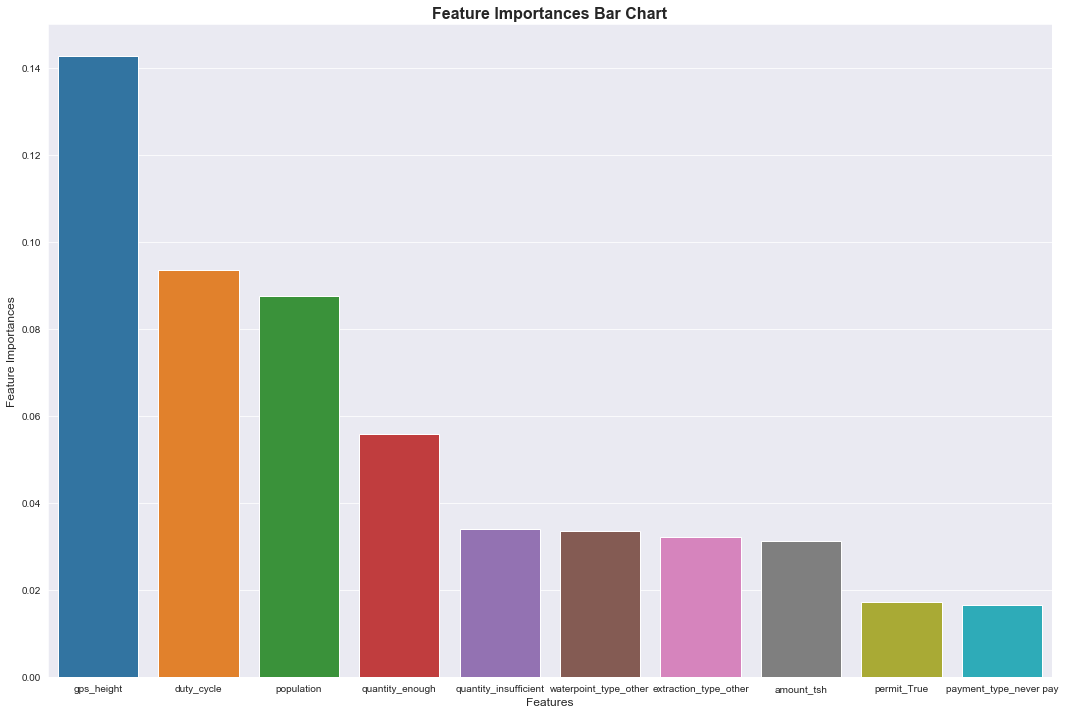

In [78]:
fig = plt.figure(figsize=(18,12))
sns.barplot(feature_importances[1][:10], feature_importances[0][:10])
plt.title('Feature Importances Bar Chart', fontsize=16, fontweight='bold')
plt.ylabel('Feature Importances', fontsize=12)
plt.ylim(0)
plt.xlabel('Features', fontsize=12)
plt.show()

This chart shows the top 10 features by their importance on affecting a change in our target variable, status_group.

## Notes

### Binary Model - OneVsRestClassifier

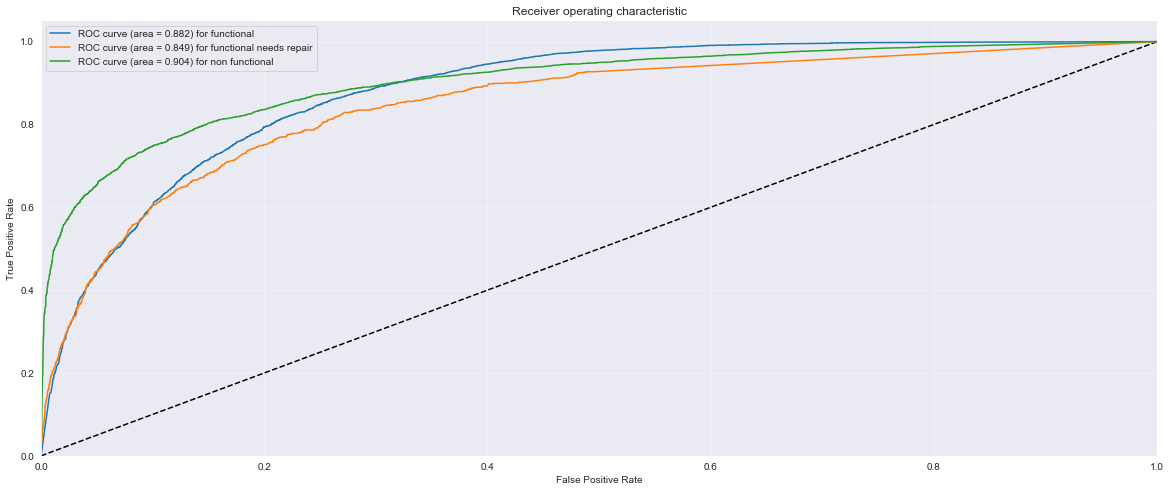

In [79]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

multi_model_rf = OneVsRestClassifier(model_rf)
multi_model_rf.fit(X_train_v,y_train_v)
y_score = multi_model_rf.predict_proba(X_test)
# structures
fpr = dict()
tpr = dict()
roc_auc = dict()
threshold = dict()
# calculate dummies once
y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
for i, label in zip(range(3),['functional', 'functional needs repair', 'non functional']):
    fpr[label], tpr[label], threshold[label] = roc_curve(y_test_dummies[:, i], y_score[:, i])
    roc_auc[label] = auc(fpr[label], tpr[label])
# roc for each class
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
for i,label in zip(range(3),['functional', 'functional needs repair', 'non functional']):
    ax.plot(fpr[label], tpr[label], label='ROC curve (area = {}) for {}'.format(round(roc_auc[label],3), label))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [80]:
y_score_df = pd.DataFrame(y_score)
y_score_df.rename(columns={0: "functional", 1: "functional needs repair", 2:"non functional"}, inplace=True)

In [1]:
a = list(y_score_df.idxmax(axis=1))

NameError: name 'y_score_df' is not defined

In [82]:
b = list(y_test_pred)

In [83]:
accuracy_score(y_test,b)

0.7886363636363637

### Threshold Selection

Non-Functional

In [84]:
prevalence = 0.38

TPc = 400
TNc = 0
FPc = 100
FNc = 1000

m = (1-prevalence)/prevalence * (FPc-TNc)/(FNc-TPc)
m

0.2719298245614035

In [85]:
fm_list = tpr['non functional']-(m*fpr['non functional'])
thresh_fm_list = list(zip(fm_list.tolist(), threshold['non functional'].tolist()))

In [86]:
thresh_fm_df = pd.DataFrame(thresh_fm_list)

In [87]:
thresh_fm_df[1][thresh_fm_df.index[thresh_fm_df[0] == thresh_fm_df[0].max()]]

2244    0.128713
Name: 1, dtype: float64

In [88]:
y_score

array([[0.01980198, 0.        , 0.98019802],
       [0.79396331, 0.        , 0.20603669],
       [0.99009901, 0.        , 0.00990099],
       ...,
       [0.73333333, 0.03809524, 0.22857143],
       [0.81280555, 0.15649085, 0.0307036 ],
       [0.27272727, 0.        , 0.72727273]])

In [89]:
from sklearn.metrics import confusion_matrix

probs_list = y_score[:,2].tolist()

my_results =[]
for x in probs_list:
    if x>0.132512:
        my_results.append(1)
    else:
        my_results.append(0)
my_results

confusion = []
for i, real in enumerate(y_test.tolist()):
    if my_results[i] == real:
        if my_results[i] == 0:
            confusion.append("TN")
        else:
            confusion.append("TP")
    else:
        if my_results[i] == 0:
            confusion.append("FN")
        else:
            confusion.append("FP")
        
pd.Series(confusion).value_counts()

FP    7279
FN    4601
dtype: int64

In [90]:
# !pip install mlxtend
from sklearn.metrics import classification_report,  confusion_matrix
from mlxtend.plotting import plot_decision_regions
# Binarising our target variable
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train_bin = encoder.fit_transform(y_train_v)
y_test_bin = encoder.fit_transform(y_test)

probs_list = y_score[:,2].tolist()

my_results =[]
for x in probs_list:
    if x>0.132512:
        my_results.append(1)
    else:
        my_results.append(0)
my_results

model =multi_model_rf
model.fit(X_train_v, pd.DataFrame(y_train_bin)[2])
y_pred = model.predict(X_test)
print(classification_report(my_results,y_pred))
print('accuracy', accuracy_score(my_results,y_pred))
display(pd.DataFrame(confusion_matrix(my_results,y_pred),
                    columns=['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive']))


              precision    recall  f1-score   support

           0       0.59      1.00      0.74      4601
           1       1.00      0.55      0.71      7279

    accuracy                           0.73     11880
   macro avg       0.79      0.78      0.72     11880
weighted avg       0.84      0.73      0.72     11880

accuracy 0.7255892255892256


,Predicted Negative,Predicted Positive
Actual Negative,4601,0
Actual Positive,3260,4019


Functional but needs Repair

In [91]:
prevalence = 0.07

TPc = 50
TNc = 200
FPc = 50
FNc = 700

m = (1-prevalence)/prevalence * (FPc-TNc)/(FNc-TPc)
m

-3.0659340659340653

In [92]:
fm_list = tpr['functional needs repair']-(m*fpr['functional needs repair'])
thresh_fm_list = list(zip(fm_list.tolist(), threshold['functional needs repair'].tolist()))

In [93]:
thresh_fm_df = pd.DataFrame(thresh_fm_list)
thresh_fm_df

,0,1
0,0.000000,2.000000
1,0.008484,1.000000
2,0.010829,0.990099
3,0.013174,0.990000
4,0.015518,0.980198
...,...,...
1511,2.444295,0.000565
1512,2.445129,0.000433
1513,2.446241,0.000385
1514,2.446798,0.000256


In [94]:
thresh_fm_df[1][thresh_fm_df.index[thresh_fm_df[0] == thresh_fm_df[0].max()]]

1515    0.0
Name: 1, dtype: float64

In [95]:
encoder = LabelBinarizer()
y_train_bin = encoder.fit_transform(y_train_v)
y_test_bin = encoder.fit_transform(y_test)

probs_list = y_score[:,1].tolist()

my_results =[]
for x in probs_list:
    if x>0:
        my_results.append(1)
    else:
        my_results.append(0)
my_results

model =multi_model_rf
model.fit(X_train_v, pd.DataFrame(y_train_bin)[1])
y_pred = model.predict(X_test)
print(classification_report(my_results,y_pred))
print('accuracy', accuracy_score(my_results,y_pred))
display(pd.DataFrame(confusion_matrix(my_results,y_pred),
                    columns=['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive']))


              precision    recall  f1-score   support

           0       0.49      1.00      0.66      5624
           1       1.00      0.07      0.13      6256

    accuracy                           0.51     11880
   macro avg       0.75      0.53      0.39     11880
weighted avg       0.76      0.51      0.38     11880

accuracy 0.5089225589225589


,Predicted Negative,Predicted Positive
Actual Negative,5624,0
Actual Positive,5834,422


In [96]:
probs_list

[0.0,
 0.0,
 0.0,
 0.020100502512562814,
 0.0,
 0.20786883587464244,
 0.009900990099009901,
 0.0,
 0.0,
 0.019230769230769232,
 0.14759499132511378,
 0.01,
 0.03571428571428571,
 0.0,
 0.07855922924048102,
 0.15836196936744318,
 0.0,
 0.0,
 0.0,
 0.3238095238095238,
 0.0,
 0.16071428571428573,
 0.0,
 0.060000000000000005,
 0.3037157801779771,
 0.0,
 0.0,
 0.15834009378605046,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06823453001695365,
 0.30067021904722685,
 0.0,
 0.11428571428571428,
 0.04255319148936171,
 0.0,
 0.22727272727272727,
 0.03260869565217391,
 0.0,
 0.16782563772088835,
 0.01,
 0.0,
 0.0,
 0.009900990099009901,
 0.0,
 0.0,
 0.00980392156862745,
 0.020658707984082633,
 0.0005446863268843302,
 0.17022017528574138,
 0.15836196936744318,
 0.00980392156862745,
 0.0024337133341872687,
 0.0,
 0.0,
 0.020202020202020204,
 0.0,
 0.0,
 0.0,
 0.0,
 0.10710536067682379,
 0.0,
 0.2957102168192764,
 0.009900990099009901,
 0.5510204081632654,
 0.0,
 0.0,
 0.0,
 0.019417475728155338,
 0.0,
 0.0,
 0.1836

Functional

In [97]:
prevalence = 0.54

TPc = 0
TNc = 200
FPc = 1000
FNc = 50

m = (1-prevalence)/prevalence * (FPc-TNc)/(FNc-TPc)
m

13.629629629629628

In [98]:
fm_list = tpr['functional']-(m*fpr['functional'])
thresh_fm_list = list(zip(fm_list.tolist(), threshold['functional'].tolist()))

In [99]:
thresh_fm_df = pd.DataFrame(thresh_fm_list)
thresh_fm_df

,0,1
0,0.000000,2.000000
1,0.044235,1.000000
2,0.044843,0.999742
3,0.045452,0.998302
4,0.043033,0.998002
...,...,...
3010,-10.197196,0.002082
3011,-10.199766,0.000556
3012,-10.204906,0.000106
3013,-10.207325,0.000103


In [100]:
thresh_fm_df[1][thresh_fm_df.index[thresh_fm_df[0] == thresh_fm_df[0].max()]]

3    0.998302
Name: 1, dtype: float64

In [101]:
encoder = LabelBinarizer()
y_train_bin = encoder.fit_transform(y_train_v)
y_test_bin = encoder.fit_transform(y_test)

probs_list = y_score[:,0].tolist()

my_results =[]
for x in probs_list:
    if x>0.989744:
        my_results.append(1)
    else:
        my_results.append(0)
my_results

model =multi_model_rf
model.fit(X_train_v, pd.DataFrame(y_train_bin)[0])
y_pred = model.predict(X_test)
print(classification_report(my_results,y_pred))
print('accuracy', accuracy_score(my_results,y_pred))
display(pd.DataFrame(confusion_matrix(my_results,y_pred),
                    columns=['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive']))

              precision    recall  f1-score   support

           0       1.00      0.48      0.65     10533
           1       0.20      1.00      0.33      1347

    accuracy                           0.54     11880
   macro avg       0.60      0.74      0.49     11880
weighted avg       0.91      0.54      0.62     11880

accuracy 0.5421717171717172


,Predicted Negative,Predicted Positive
Actual Negative,5094,5439
Actual Positive,0,1347


### Error bars - Feature importances

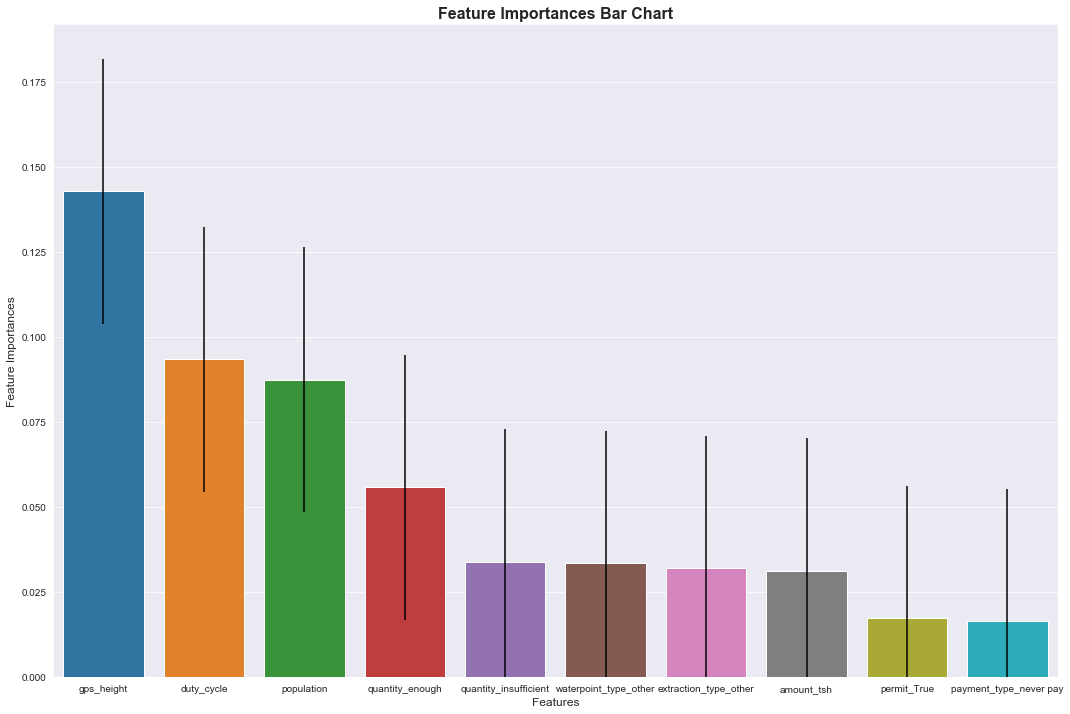

In [102]:
fig = plt.figure(figsize=(18,12))
sns.barplot(feature_importances[1][:10], feature_importances[0][:10], yerr=np.std(feature_importances[0][:10]))
plt.title('Feature Importances Bar Chart', fontsize=16, fontweight='bold')
plt.ylabel('Feature Importances', fontsize=12)
plt.ylim(0)
plt.xlabel('Features', fontsize=12)
plt.show()

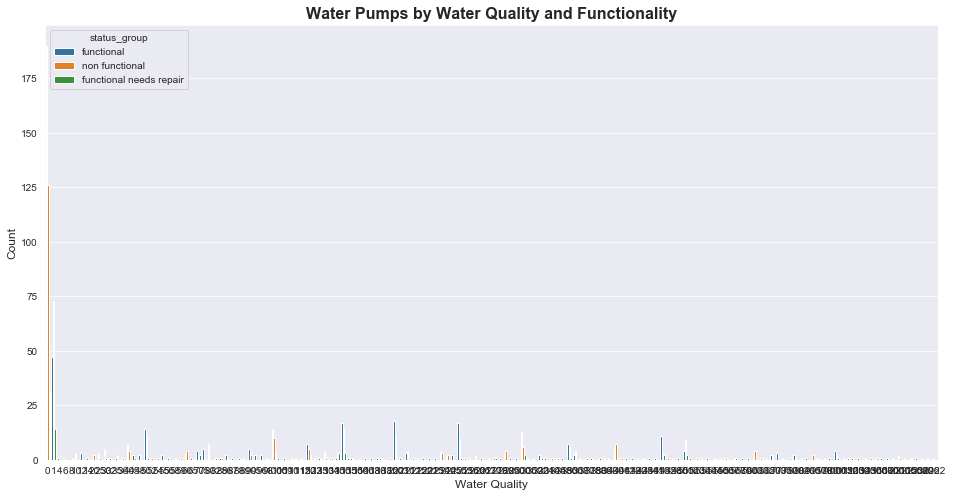

In [103]:
plt.figure(figsize=(16,8))

ax = sns.countplot(data=df[:1000], x='population', hue='status_group')

plt.title('Water Pumps by Water Quality and Functionality', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Water Quality', fontsize=12)
plt.show()